In [115]:
import trino
import pandas as pd
import seaborn as sns
from minio import Minio
import matplotlib.pyplot as plt

## Подключения

In [116]:
client = Minio(
    "localhost:9000",
    access_key="admin",
    secret_key="admin123",
    secure=False,
)

In [129]:
conn = trino.dbapi.connect(
    host="localhost",
    port=8080,
    user="admin",
    catalog="iceberg",
    schema="public",
)

In [130]:
cur = conn.cursor()

In [131]:
def q(sql: str) -> pd.DataFrame | None:
    cur.execute(sql)
    if cur.description is None:
        return None
    rows = cur.fetchall()
    cols = [c[0] for c in cur.description]
    return pd.DataFrame(rows, columns=cols)

In [173]:
q("SELECT 1 AS ok")

,ok
0,1


In [174]:
q("SHOW CATALOGS")

,Catalog
0,iceberg
1,mysql
2,postgresql
3,system


In [190]:
q("SHOW SCHEMAS FROM iceberg")

,Schema
0,information_schema
1,system


In [176]:
q("SHOW SCHEMAS FROM postgresql")

,Schema
0,information_schema
1,pg_catalog
2,public


In [177]:
q("SHOW TABLES FROM postgresql.public")

,Table
0,customer_orders
1,customer_profiles


In [178]:
q("SHOW SCHEMAS FROM mysql")

,Schema
0,demo_db
1,information_schema
2,performance_schema


In [179]:
q("SHOW TABLES FROM mysql.demo_db")

,Table
0,financial_transactions


## Агрегация данных

In [180]:
df_orders_daily = q("""
SELECT
  date(order_date) AS day,
  count(*) AS orders_cnt,
  count(DISTINCT profile_id) AS buyers_cnt,
  CAST(round(sum(total_cost), 2) AS DOUBLE) AS revenue,
  CAST(round(avg(total_cost), 2) AS DOUBLE) AS avg_check
FROM postgresql.public.customer_orders
GROUP BY 1
ORDER BY day
""")

df_orders_daily

,day,orders_cnt,buyers_cnt,revenue,avg_check
0,2024-01-01,2,2,176.0,88.00
1,2024-01-02,2,2,345.4,172.70
2,2024-01-03,2,2,275.6,137.80
3,2024-01-04,2,2,231.2,115.60
4,2024-01-05,2,2,385.7,192.85


In [181]:
df_top_customers_txn = q("""
SELECT
  customer_id,
  count(*) AS txn_cnt,
  CAST(round(sum(total_amount), 2) AS DOUBLE) AS txn_total,
  CAST(round(avg(total_amount), 2) AS DOUBLE) AS txn_avg
FROM mysql.demo_db.financial_transactions
GROUP BY 1
ORDER BY txn_total DESC
LIMIT 5
""")

df_top_customers_txn

,customer_id,txn_cnt,txn_total,txn_avg
0,2010,1,220.4,220.4
1,2005,1,210.0,210.0
2,2008,1,185.6,185.6
3,2003,1,180.0,180.0
4,2007,1,150.0,150.0


In [182]:
df_payment_mix = q("""
SELECT
  payment_type,
  count(*) AS txn_cnt,
  CAST(round(sum(total_amount), 2) AS DOUBLE) AS txn_total
FROM mysql.demo_db.financial_transactions
GROUP BY 1
ORDER BY txn_total DESC
""")

df_payment_mix


,payment_type,txn_cnt,txn_total
0,bank_transfer,3,550.40
1,credit_card,3,395.30
2,paypal,2,281.10
3,debit_card,2,220.75


In [183]:
df_txn_daily = q("""
SELECT
  date(transaction_time) AS day,
  count(*) AS transactions_cnt,
  CAST(round(sum(total_amount), 2) AS DOUBLE) AS transactions_total,
  CAST(round(avg(total_amount), 2) AS DOUBLE) AS transactions_avg
FROM mysql.demo_db.financial_transactions
GROUP BY 1
ORDER BY day
""")

df_final = (
    df_orders_daily
    .merge(df_txn_daily, on="day", how="outer")
    .sort_values("day")
)

df_final

,day,orders_cnt,buyers_cnt,revenue,avg_check,transactions_cnt,transactions_total,transactions_avg
0,2024-01-01,2.0,2.0,176.0,88.00,1,120.00,120.00
1,2024-01-02,2.0,2.0,345.4,172.70,2,245.30,122.65
2,2024-01-03,2.0,2.0,275.6,137.80,2,305.50,152.75
3,2024-01-04,2.0,2.0,231.2,115.60,2,270.75,135.38
4,2024-01-05,2.0,2.0,385.7,192.85,1,185.60,185.60
5,2024-01-06,NaN,NaN,NaN,NaN,2,320.40,160.20


## Визуализация

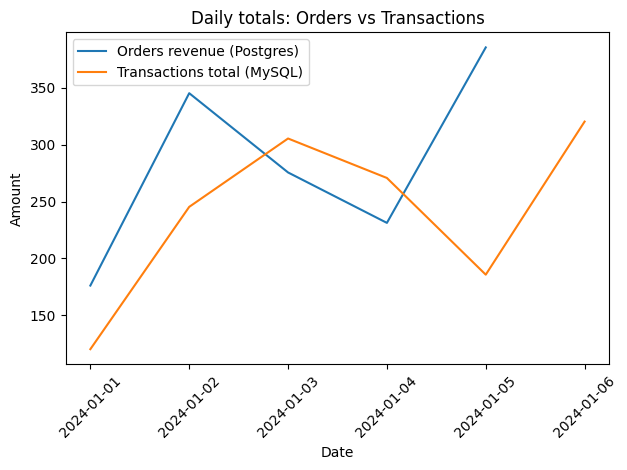

In [184]:
plt.figure()
plt.plot(df_final["day"], df_final["revenue"], label="Orders revenue (Postgres)")
plt.plot(df_final["day"], df_final["transactions_total"], label="Transactions total (MySQL)")
plt.title("Daily totals: Orders vs Transactions")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

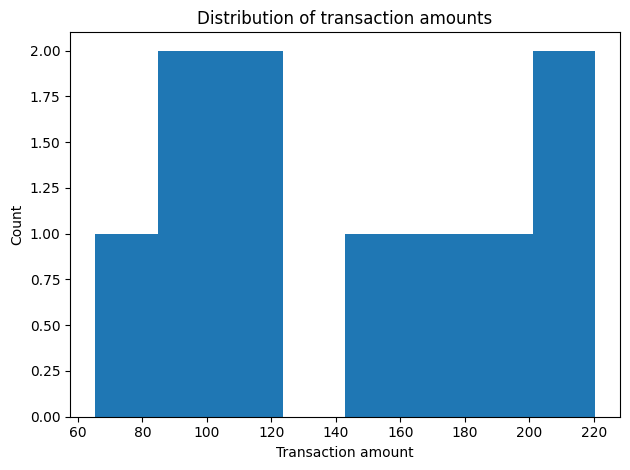

In [185]:
df_txn_raw = q("""
SELECT total_amount
FROM mysql.demo_db.financial_transactions
""")

plt.figure()
plt.hist(df_txn_raw["total_amount"], bins=8)
plt.title("Distribution of transaction amounts")
plt.xlabel("Transaction amount")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


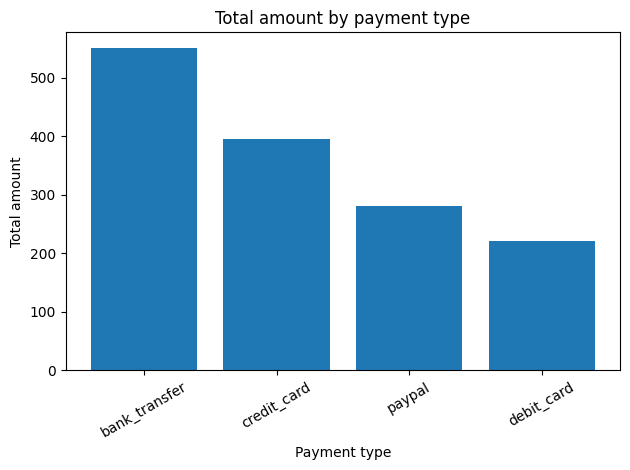

In [186]:
plt.figure()
plt.bar(df_payment_mix["payment_type"], df_payment_mix["txn_total"])
plt.title("Total amount by payment type")
plt.xlabel("Payment type")
plt.ylabel("Total amount")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Iceberg

In [194]:
q("""
CREATE SCHEMA IF NOT EXISTS iceberg.analytics
WITH (location = 's3://lakehouse-warehouse/analytics/')
""")

q("DELETE FROM iceberg.analytics.daily_kpis")

q("""
INSERT INTO iceberg.analytics.daily_kpis
SELECT
  coalesce(o.day, t.day) AS day,
  o.orders_cnt,
  o.buyers_cnt,
  o.revenue,
  o.avg_check,
  t.transactions_cnt,
  t.transactions_total,
  t.transactions_avg
FROM (
  SELECT
    date(order_date) AS day,
    count(*) AS orders_cnt,
    count(DISTINCT profile_id) AS buyers_cnt,
    CAST(round(sum(total_cost), 2) AS DOUBLE) AS revenue,
    CAST(round(avg(total_cost), 2) AS DOUBLE) AS avg_check
  FROM postgresql.public.customer_orders
  GROUP BY 1
) o
FULL OUTER JOIN (
  SELECT
    date(transaction_time) AS day,
    count(*) AS transactions_cnt,
    CAST(round(sum(total_amount), 2) AS DOUBLE) AS transactions_total,
    CAST(round(avg(total_amount), 2) AS DOUBLE) AS transactions_avg
  FROM mysql.demo_db.financial_transactions
  GROUP BY 1
) t
ON o.day = t.day
""")

q("SELECT * FROM iceberg.analytics.daily_kpis ORDER BY day DESC")

,day,orders_cnt,buyers_cnt,revenue,avg_check,transactions_cnt,transactions_total,transactions_avg
0,2024-01-06,NaN,NaN,NaN,NaN,2,320.40,160.20
1,2024-01-05,2.0,2.0,385.7,192.85,1,185.60,185.60
2,2024-01-04,2.0,2.0,231.2,115.60,2,270.75,135.38
3,2024-01-03,2.0,2.0,275.6,137.80,2,305.50,152.75
4,2024-01-02,2.0,2.0,345.4,172.70,2,245.30,122.65
5,2024-01-01,2.0,2.0,176.0,88.00,1,120.00,120.00
